In [292]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils.parametrize as parameterize

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [293]:
"""
Load the data set we will be working with
"""

data_dir = 'Datasets'
study = 'study_213'
filename = 'top_5_213_linear.csv'

df = pd.read_csv(f'{data_dir}/{study}/{filename}')
df.drop(columns = ['DATE'], inplace = True)
df = (df - df.mean()) / df.std()

train_percent = 80
train_len = int(len(df) * (train_percent / 100))
train = df.head(train_len)
test = df.tail(len(df) - train_len)

print(len(train), len(test))

FileNotFoundError: [Errno 2] No such file or directory: 'Datasets/study_213/top_5_study_213_linear.csv'

In [ ]:
# the lag is the amount of historical data we provide to the model
lag = 5

adjacency_matrix = np.array([
    [0, 1, 1, 1, 1],
    [1, 0, 1, 1, 1],
    [1, 1, 0, 1, 0],
    [1, 1, 1, 0, 1],
    [1, 1, 0, 1, 0],
])

The general network autoregressive model is:

$$AR(X_t) = \sum_{i = 0}^p \phi_i X_{t - i} + \sum_Y \sum_{i = 0}^p \theta^Y_i Y_{t - i} + \epsilon$$

Where the $\phi_i$ and $\theta_i^Y$ are the learned parameters, $\epsilon$ is noise, and each $Y$ is a neighbor of $X$. For forcasting, we remove the $\epsilon$ and treat the output as the expected value at the next timestep.

In [ ]:
class logexp(nn.Module):
    def forward(self, X):
        return torch.exp(X)

class NARModel(nn.Module):

    def __init__(self, lag, adj_mat):
        super().__init__()

        # We will use the adj_mat to determine which linear models need to be applied
        self.adj_mat = adj_mat
        self.channels = len(adj_mat)

        # The basic autoregressive model is simply a linear combination of the last values
        # For the network varient, we will create a matrix of linear models, applying the ones that
        # correspond to edges in the underlying network
        # Note that in reality, each linear model should have lag inputs and only one output, however to simplify
        # working with torch, we allow for self.channels outputs, which will then by multiplied by a vector with exactly
        # one coordinate set to one. This will effectively reduce the number of outputs to one, but will make vector
        # operations in the forward pass easier
        self.model = nn.ModuleList([nn.ModuleList([nn.Linear(lag, self.channels) for _ in range(self.channels)]) for _ in range(self.channels)])

        # We can require all weights to be positive using the above logexp module
        # that relate an element to itself
        # for i in range(self.channels):
        #     parameterize.register_parametrization(self.model[i][i], 'weight', logexp())

        # store the lag in case we need it
        self.lag = lag

        # store the identity matrix, which is used to simplify the forward pass
        self.eye = torch.eye(self.channels)

    def forward(self, input):
        output = torch.zeros(self.channels)

        for i in range(self.channels):
            # We always apply the auto regressive model to the current node
            output += self.model[i][i](input[i]) * self.eye[i]

            # For each other node, we only apply the model if the nodes are connected
            # in the adjacency matrix
            for j in range(self.channels):
                if self.adj_mat[i][j] == 0 or i == j: continue
                output += self.model[i][j](input[j]) * self.eye[i]

        return output
    
    def fit(self, data, iters = 200, lr = 0.001, verbose = False):
        # We will use 100 iterations of stochastic gradient descent with a learning rate
        # of 0.001
        optimizer = optim.Adam(self.parameters(), lr = lr)

        # Mean Square Error loss
        loss_fn = nn.MSELoss()

        # First generate the sequences of inputs and outputs in the proper tensor format
        input, output = [], []
        for i in range(self.lag, len(data[0])):
            curr_input = []
            curr_output = []
            for j in range(self.channels):
                curr_input.append(data[j][i - self.lag:i])
                curr_output.append(data[j][i])
            input.append(torch.tensor(curr_input, dtype = torch.float32))
            output.append(torch.tensor(curr_output, dtype = torch.float32))

        for _ in range(iters):
            total_loss = 0
            for x, y in zip(input, output):
                # We need to zero the gradients for each optimization step
                optimizer.zero_grad()

                # Calculate the loss for this step
                pred = self.forward(x)
                loss = loss_fn(pred, y)
                total_loss += loss

                # Backpropagate the loss
                loss.backward()

                # Step the optimizer forward to update the parameters
                optimizer.step()
            if verbose: print(f'total loss: {total_loss:.4f}')


In [ ]:
model = NARModel(lag, adjacency_matrix)

all_data = []
for s in train.columns:
    all_data.append(train[s].tolist())
model.fit(all_data, verbose=True)

total loss: 225.7799
total loss: 206.4428
total loss: 188.8233
total loss: 172.6844
total loss: 157.9916
total loss: 144.6667
total loss: 132.6205
total loss: 121.7610
total loss: 111.9974
total loss: 103.2414
total loss: 95.4078
total loss: 88.4152
total loss: 82.1861
total loss: 76.6471
total loss: 71.7293
total loss: 67.3681
total loss: 63.5033
total loss: 60.0796
total loss: 57.0457
total loss: 54.3553
total loss: 51.9662
total loss: 49.8405
total loss: 47.9443
total loss: 46.2478
total loss: 44.7246
total loss: 43.3517
total loss: 42.1089
total loss: 40.9790
total loss: 39.9472
total loss: 39.0007
total loss: 38.1287
total loss: 37.3218
total loss: 36.5724
total loss: 35.8735
total loss: 35.2197
total loss: 34.6059
total loss: 34.0282
total loss: 33.4829
total loss: 32.9670
total loss: 32.4780
total loss: 32.0135
total loss: 31.5717
total loss: 31.1509
total loss: 30.7496
total loss: 30.3665
total loss: 30.0005
total loss: 29.6506
total loss: 29.3160
total loss: 28.9959
total loss

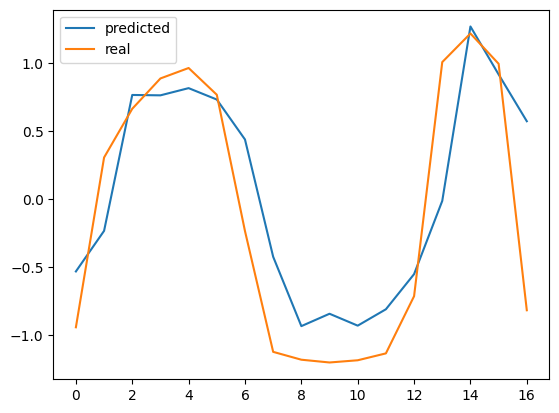

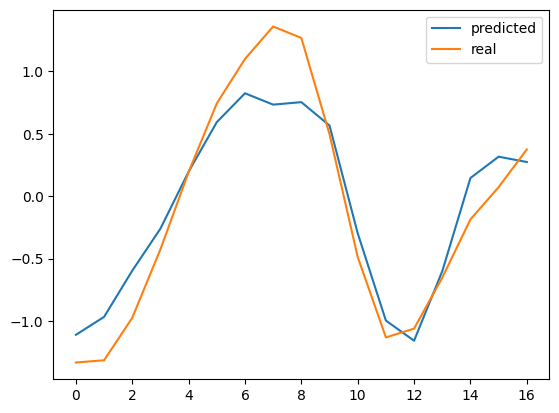

MSE: 0.3624
RMSE: 0.6020
MAE: 0.6186


In [ ]:
x = [i for i in range(len(test) - lag)]

data = []
for s in test.columns:
    data.append(test[s].tolist())

mse_loss = 0
l1_loss = 0

for s in range(len(data)):
    _, ax = plt.subplots()
    expected, predictions = [], []
    for i in range(lag, len(test)):
        input = []
        for stream in data:
            input.append(stream[i - lag:i])
        expected.append(data[s][i])
        input = torch.tensor(input, dtype = torch.float32)
        predictions.append(model.forward(input).detach().numpy()[s])

    # Calculate the Mean Square Error for this model
    mse_loss += nn.functional.mse_loss(torch.tensor(predictions), torch.tensor(expected))
    l1_loss += nn.functional.l1_loss(torch.tensor(predictions), torch.tensor(expected))
        
    ax.plot(x, predictions, label = 'predicted')
    ax.plot(x, expected, label = 'real')
    plt.legend()
    plt.show()

print(f'MSE: {mse_loss:.4f}')
print(f'RMSE: {torch.sqrt(mse_loss):.4f}')
print(f'MAE: {l1_loss:.4f}')

In [ ]:
for ml in model.model:
    for l in ml:
        display(l.weight)

Parameter containing:
tensor([[-0.2649,  0.7872],
        [ 0.6391, -0.5154]], requires_grad=True)

Parameter containing:
tensor([[-0.3257,  0.1514],
        [ 0.0361,  0.3823]], requires_grad=True)

Parameter containing:
tensor([[-0.0686, -0.2262],
        [-0.1047,  0.2012]], requires_grad=True)

Parameter containing:
tensor([[ 0.3650,  0.4271],
        [-0.6103,  1.1950]], requires_grad=True)